## Univariate TS analysis and Forecasting
In this notebook, I have tried to analysed and built a forecast model on the air passengers dataset. Below are the steps followed to perform Univariate statistical Time Series analysis and Time Series forecasting  on the air passengers dataset.  
1. Stationarity using ADF
2. Train-Test split
3. Compute p,q,d values 
4. Build & compare the AR,MA,ARIMA,SAIRMAX models on the train
5. Build final model
6. Forecasting into future




In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [2]:
air_passengers=pd.read_csv('airline_passengers.csv', 
                           index_col='Month',
                          parse_dates=True)
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


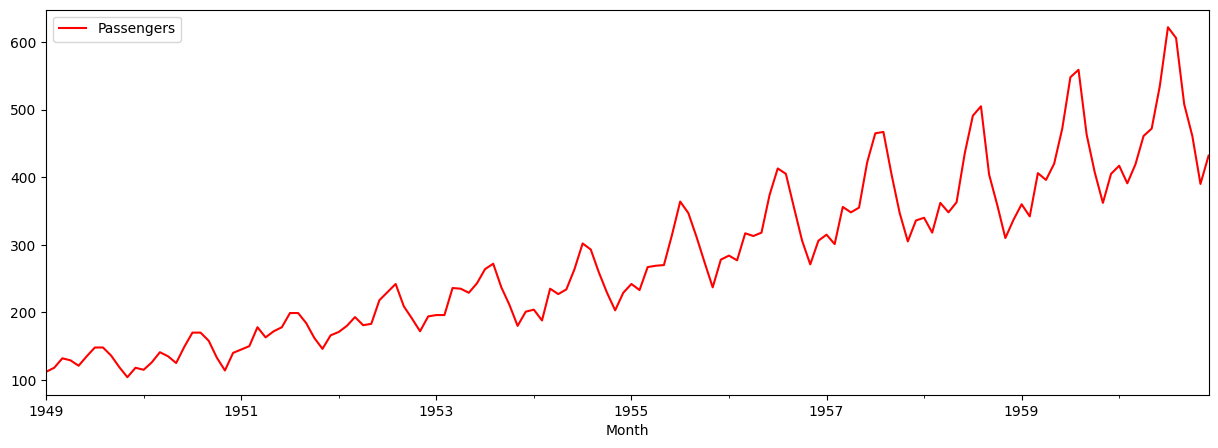

In [3]:
air_passengers.plot(figsize=(15,5), color='red')
plt.show()

In [4]:
df=air_passengers.copy()

### 1. Stationarity using ADF
The time series should be close to stationary i.e., the mean and sd should remain constant in the series 

* Check for stationarity using ADF test
* If not stationary perform any of the transformations
    1. log transformation
    2. subtracting simple moving average
    3. subtracting exponential moving average
    4. subtracting from previous value (shift)
    5. seasonal decomposition

In [5]:
# check for stationarity
def adf_test(x):
    """
    Method takes a series and checks if its stationary
    """
    res=adfuller(x)
    print(f"Test-Statistic : {res[0]}")
    print(f"P-value        : {res[1]}")
    if res[1] < 0.05:
        print("Result     : Stationary")
    else:
        print("Result     : Non-Stationary")
        
adf_test(x=df['Passengers'])

Test-Statistic : 0.8153688792060442
P-value        : 0.9918802434376409
Result     : Non-Stationary


### 2. Convert to statonary

In [6]:
# 1. log transformation
df['LogPassengers']=np.log(df['Passengers'])
# check for stationarity
adf_test(x=df['LogPassengers'])

Test-Statistic : -1.7170170891069634
P-value        : 0.42236677477038986
Result     : Non-Stationary


In [7]:
# 2. differencing simple moving average from log
df['LogMA_diff']=df['LogPassengers'].rolling(12).mean() - df['LogPassengers']
adf_test(x=df['LogMA_diff'].dropna())

Test-Statistic : -3.1629079913008744
P-value        : 0.022234630001242813
Result     : Stationary


In [8]:
# 3. differencing exp moving average from log
df['LogEMA_diff']=df['LogPassengers'].ewm(halflife=12, min_periods=0, adjust=True).mean() - df['LogPassengers']
adf_test(x=df['LogEMA_diff'].dropna())

Test-Statistic : -3.6012624201616816
P-value        : 0.005736938801511787
Result     : Stationary


In [9]:
# 4. Differencing previous values (shift=1)
df['Logshift1']=df['LogPassengers'] - df['LogPassengers'].shift(1)
adf_test(x=df['Logshift1'].dropna())

print("-"*50)

# 4.a Differencing previous values (shift=2)
df['Logshift2']=df['LogPassengers'] - df['LogPassengers'].shift(2)
adf_test(x=df['Logshift2'].dropna())

Test-Statistic : -2.7171305983881138
P-value        : 0.07112054815086194
Result     : Non-Stationary
--------------------------------------------------
Test-Statistic : -3.1679073752887312
P-value        : 0.021919114564039645
Result     : Stationary


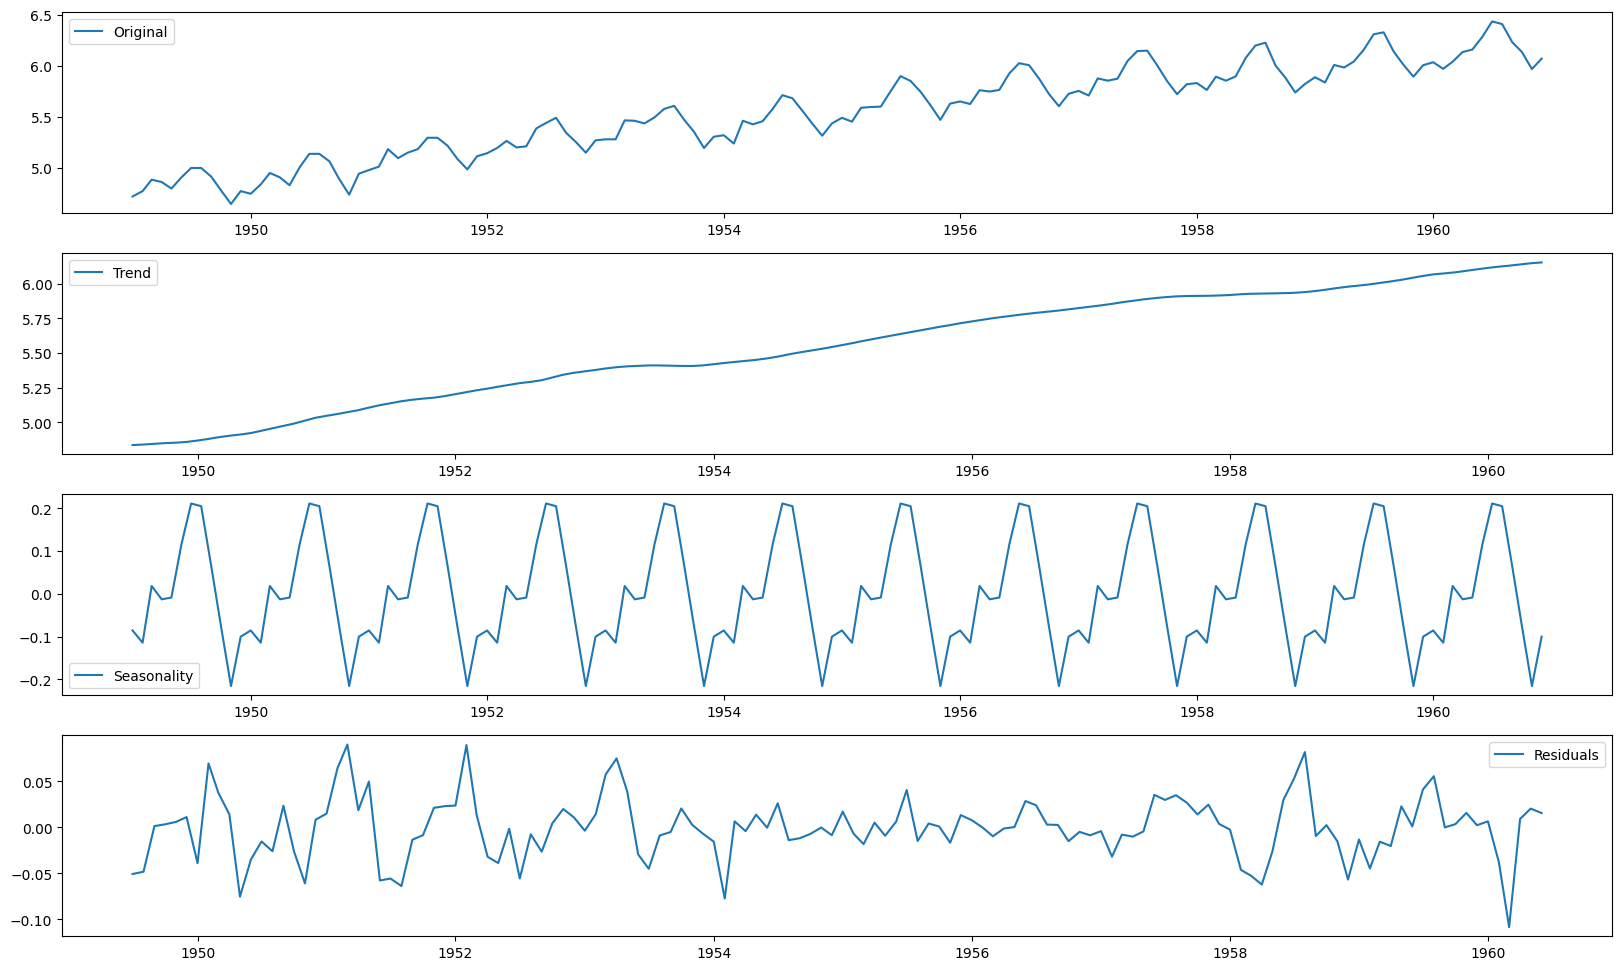

--------------------------------------------------
Test-Statistic : -6.3323867976448724
P-value        : 2.8850589033232728e-08
Result     : Stationary


In [10]:
# 5. Seasonal decomposition - decompose it in to Trend, Seasonality, Cyclicity
df1=air_passengers.copy()
df1['LogPassengers']=np.log(df['Passengers'])
df1.drop(['Passengers'],axis=1,inplace=True)

decomposition=seasonal_decompose(df1)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid



plt.figure(figsize=(20, 12))
plt.subplot(4,1,1)
plt.plot(df1, label='Original')
plt.legend(loc='best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

print("-"*50)
adf_test(x=residual.dropna())

By performing the above types of transformations the non stationary TS can be converted to stationary TS

In [11]:
df.head()

,Passengers,LogPassengers,LogMA_diff,LogEMA_diff,Logshift1,Logshift2
Month,,,,,,
1949-01-01,112,4.718499,NaN,0.000000,NaN,NaN
1949-02-01,118,4.770685,NaN,-0.025339,0.052186,NaN
1949-03-01,132,4.882802,NaN,-0.088967,0.112117,0.164303
1949-04-01,129,4.859812,NaN,-0.048028,-0.022990,0.089128
1949-05-01,121,4.795791,NaN,0.012415,-0.064022,-0.087011


In [12]:
# using the Logshift transformed series
Logshift2_df=df[['Logshift2']].dropna()
Logshift2_df.head()

,Logshift2
Month,
1949-03-01,0.164303
1949-04-01,0.089128
1949-05-01,-0.087011
1949-06-01,0.045462
1949-07-01,0.201422


### 2. Train-Test split

In [13]:
# train test split
len(Logshift2_df)
Logshift2_df_train=Logshift2_df[:100]
Logshift2_df_test=Logshift2_df[100:]
print(f"Train size: {len(Logshift2_df_train)}")
print(f"Test size : {len(Logshift2_df_test)}")

Train size: 100
Test size : 42


### 3. Compute p,q,d values 

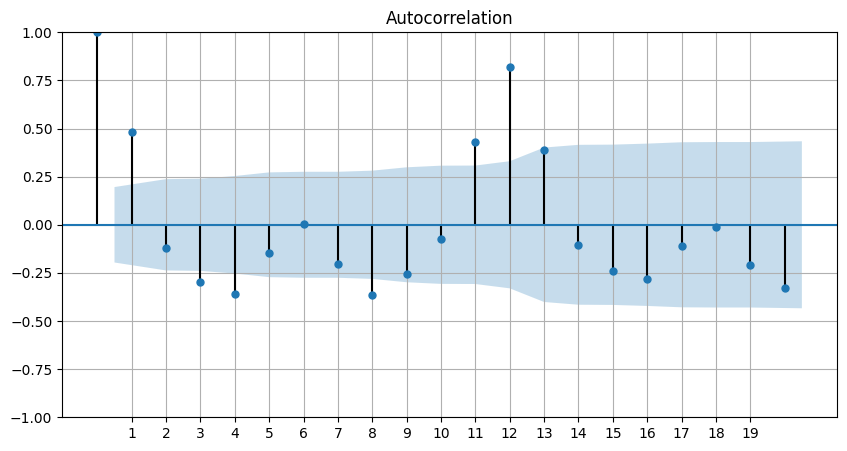

In [14]:
# compute p,q,d values using the acf and pacf plots
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(Logshift2_df_train['Logshift2'], ax=ax)
plt.xticks([i for i in range(1,20)])
plt.grid()
plt.show()

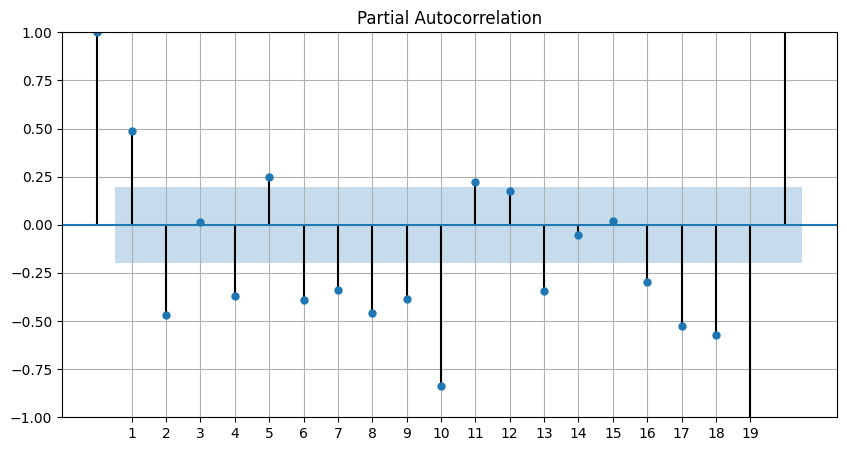

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(Logshift2_df_train['Logshift2'], ax=ax)
plt.xticks([i for i in range(1,20)])
plt.grid()
plt.show()

**From the above plot q=1, p=1**

### 4. Build & compare model - AR, MA, ARIMA, SARIMA, SARIMAX   

In [16]:
# params
p=1
q=1
d=1

In [17]:

import warnings
warnings.filterwarnings('ignore')

def plot_models(y_actual,y_pred):    
    """
    Method computes the RMSE and plots the y actual and y predicted
    """
    # compute RMSE
    rmse=mean_squared_error(y_actual, y_pred, squared=False)
    rmse=round(rmse,4)
    # plot
    plt.figure(figsize=(15,5)) 
    plt.plot(y_actual)
    plt.plot(y_pred, color='red')
    plt.title(f'RMSE: {rmse}')
    plt.xticks(y_actual.index[0::12], rotation ='vertical')
    plt.grid()
    plt.show()

###  AutoRegressive Model (AR)

                               SARIMAX Results                                
Dep. Variable:              Logshift2   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  57.797
Date:                Sun, 15 Jan 2023   AIC                           -109.595
Time:                        13:20:42   BIC                           -101.779
Sample:                    03-01-1949   HQIC                          -106.432
                         - 06-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0271      0.028      0.980      0.327      -0.027       0.081
ar.L1          0.4870      0.099      4.908      0.000       0.292       0.681
sigma2         0.0184      0.005      3.688      0.0

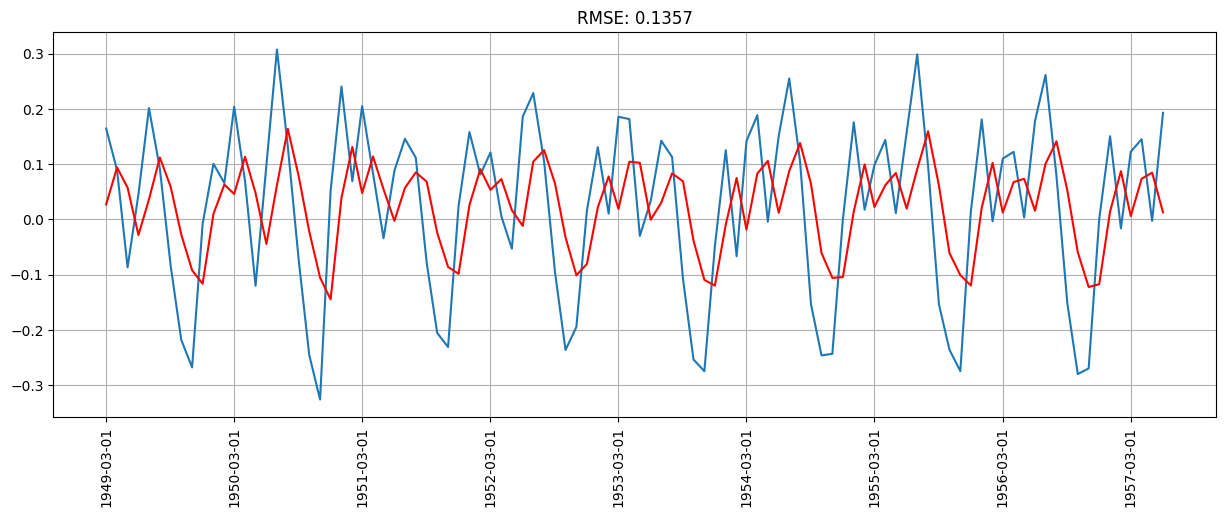

In [18]:

# model=AutoReg(Logshift2_df,lags=2 ,old_names=False)
model=ARIMA(Logshift2_df_train, order=(p,0,0)).fit()
print(model.summary())


y_actual=Logshift2_df_train.dropna()
y_pred=model.fittedvalues

plot_models(y_actual,y_pred)

**Analysis**. 
* The p-values are also significantly lower than 0.05
* Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC) and Log Likelihood are used for comparision

### MovingAverage Model (MA)

                               SARIMAX Results                                
Dep. Variable:              Logshift2   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  82.818
Date:                Sun, 15 Jan 2023   AIC                           -159.635
Time:                        13:20:42   BIC                           -151.820
Sample:                    03-01-1949   HQIC                          -156.472
                         - 06-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.021      1.272      0.203      -0.014       0.066
ma.L1          0.9999     21.794      0.046      0.963     -41.715      43.715
sigma2         0.0107      0.233      0.046      0.9

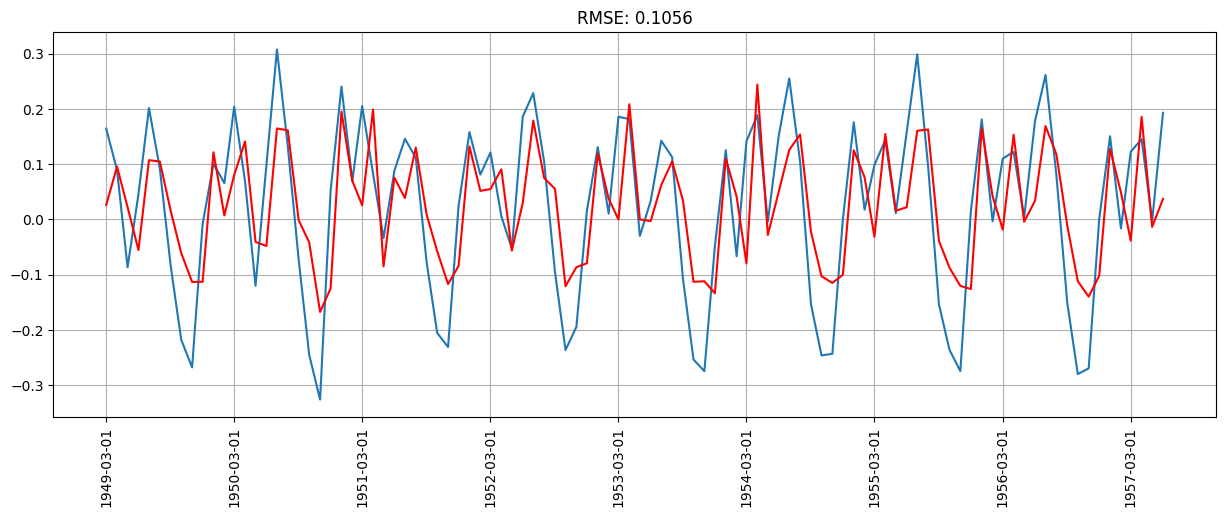

In [19]:
model=ARIMA(Logshift2_df_train, order=(0,0,q)).fit()
print(model.summary())

y_actual=Logshift2_df_train.dropna()
y_pred=model.fittedvalues

plot_models(y_actual,y_pred)

###  ARIMA 

                               SARIMAX Results                                
Dep. Variable:              Logshift2   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  60.981
Date:                Sun, 15 Jan 2023   AIC                           -115.961
Time:                        13:20:42   BIC                           -108.176
Sample:                    03-01-1949   HQIC                          -112.811
                         - 06-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3307      0.153     -2.166      0.030      -0.630      -0.031
ma.L1          1.0000     91.919      0.011      0.991    -179.158     181.158
sigma2         0.0164      1.509      0.011      0.9

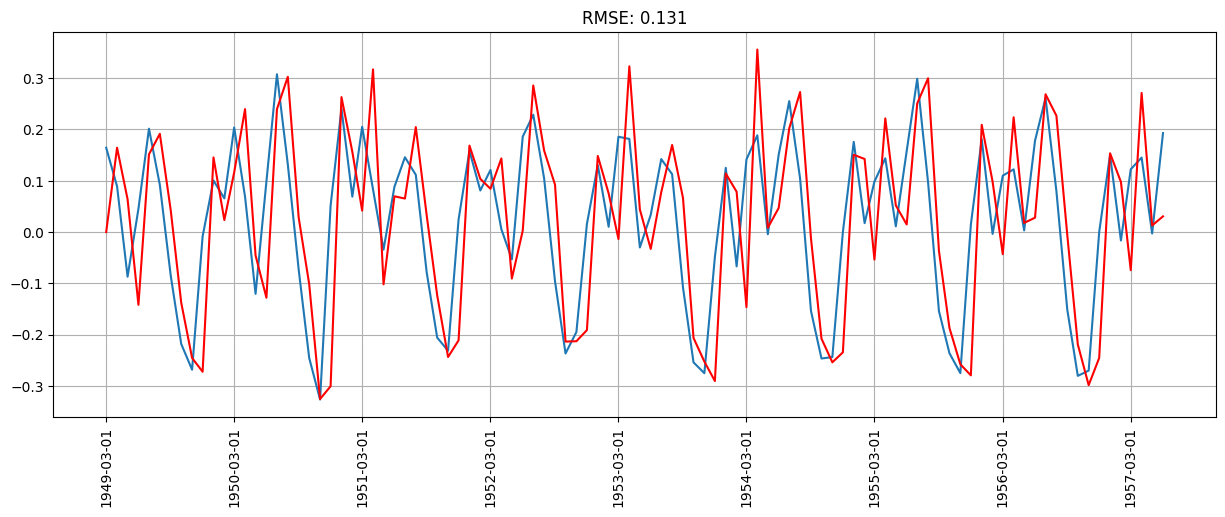

In [20]:
model=ARIMA(Logshift2_df_train, order=(p,d,q)).fit()
print(model.summary())

y_actual=Logshift2_df_train.dropna()
y_pred=model.fittedvalues

plot_models(y_actual,y_pred)

Since there is a seasonality in the dataset, SARIMAX model can give better results

### ARIMA with Seasonal 

                                    SARIMAX Results                                     
Dep. Variable:                        Logshift2   No. Observations:                  100
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 141.022
Date:                          Sun, 15 Jan 2023   AIC                           -272.045
Time:                                  13:20:43   BIC                           -259.715
Sample:                              03-01-1949   HQIC                          -267.080
                                   - 06-01-1957                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3190      0.140      2.284      0.022       0.045       0.593
ma.L1         -0.9999     26.172     -0.038      0.

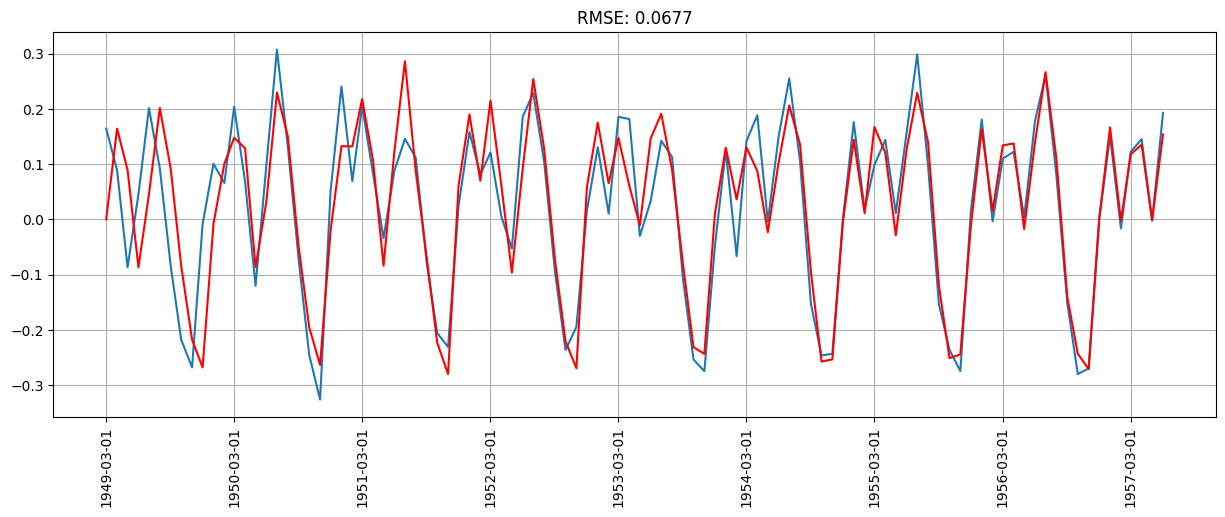

In [21]:
model=ARIMA(Logshift2_df_train, order=(p,d,q), seasonal_order=(1,1,1,12)).fit()
print(model.summary())

y_actual=Logshift2_df_train.dropna()
y_pred=model.fittedvalues

plot_models(y_actual,y_pred)

### SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23686D+00    |proj g|=  2.84624D+00

At iterate    5    f= -1.25781D+00    |proj g|=  2.05187D+00

At iterate   10    f= -1.31066D+00    |proj g|=  1.66841D-01

At iterate   15    f= -1.39229D+00    |proj g|=  1.81004D+00


 This problem is unconstrained.



At iterate   20    f= -1.40407D+00    |proj g|=  1.36506D-02

At iterate   25    f= -1.40613D+00    |proj g|=  3.14845D-01

At iterate   30    f= -1.40980D+00    |proj g|=  1.83954D-01

At iterate   35    f= -1.41020D+00    |proj g|=  2.15068D-02

At iterate   40    f= -1.41022D+00    |proj g|=  6.29354D-03

At iterate   45    f= -1.41022D+00    |proj g|=  8.84200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     80      1     0     0   3.194D-03  -1.410D+00
  F =  -1.4102249215251685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Result


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


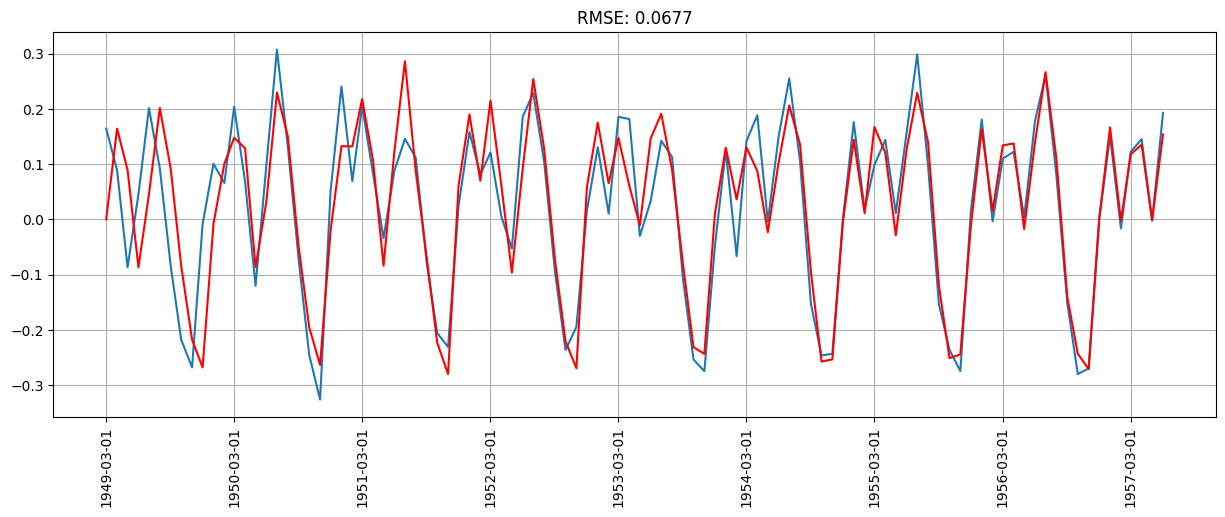

In [22]:
model=SARIMAX(Logshift2_df_train, order=(p,d,q), seasonal_order=(1,1,1,12)).fit()
print(model.summary())

y_actual=Logshift2_df_train.dropna()
y_pred=model.fittedvalues

plot_models(y_actual,y_pred)

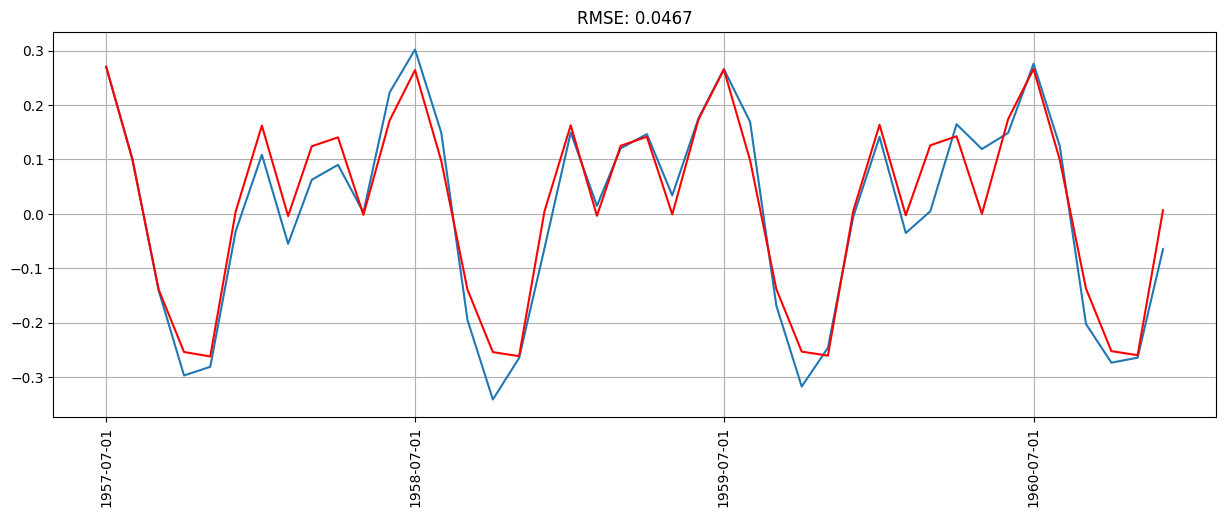

In [23]:
#Predictions on Test set
y_pred=model.forecast(steps=42)
y_actual=Logshift2_df_test.dropna()
plot_models(y_actual,y_pred)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19302D+00    |proj g|=  3.87303D-02

At iterate    5    f=  3.19035D+00    |proj g|=  3.05935D-02

At iterate   10    f=  3.18815D+00    |proj g|=  2.20412D-03

At iterate   15    f=  3.18809D+00    |proj g|=  2.10562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.409D-05   3.188D+00
  F =   3.1880849677106022     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


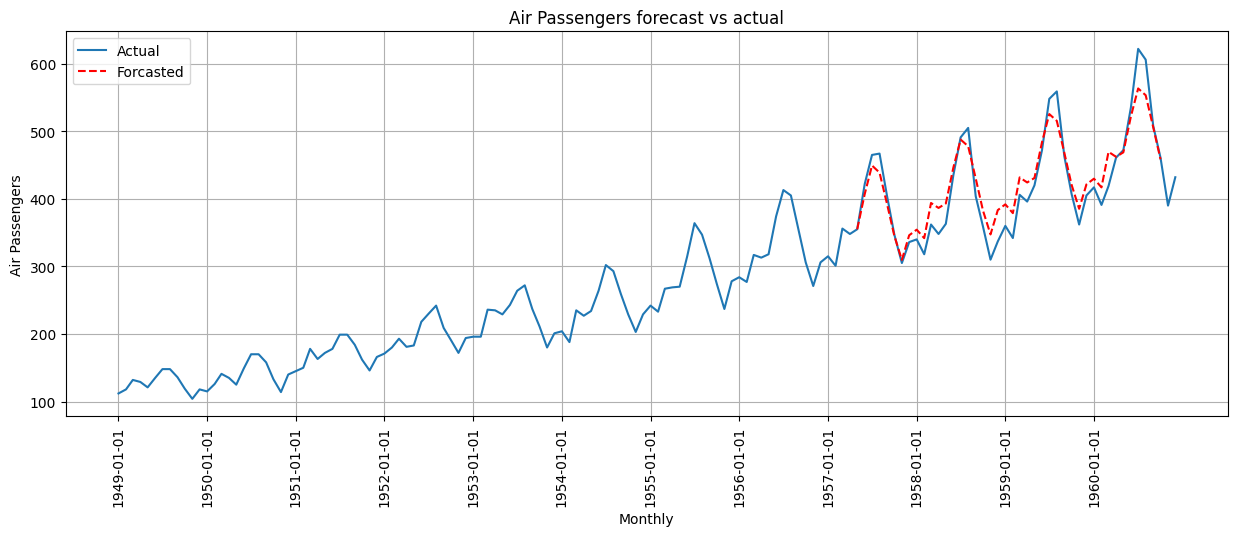

In [25]:
# forecast and compare with the test set

model=SARIMAX(df[['Passengers']][:100], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
y_pred=model.forecast(steps=42)

# plot
plt.figure(figsize=(15,5)) 
plt.plot(df[['Passengers']], label='Actual')
plt.plot(y_pred, color='red', label='Forcasted',linestyle="--")
plt.xticks(df[['Passengers']].index[0::12], rotation ='vertical')
plt.legend(loc="upper left")
plt.xlabel("Monthly")
plt.ylabel("Air Passengers")
plt.title("Air Passengers forecast vs actual")
plt.grid()
plt.show()

### 5. Build final model

In [26]:
# build final model
model=SARIMAX(df[['Passengers']], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
print(model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52844D+00    |proj g|=  8.65844D-02

At iterate    5    f=  3.52337D+00    |proj g|=  3.73532D-02

At iterate   10    f=  3.51577D+00    |proj g|=  4.96154D-03

At iterate   15    f=  3.51498D+00    |proj g|=  1.97401D-03

At iterate   20    f=  3.51493D+00    |proj g|=  7.04749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   3.464D-05   3.515D+00
  F =   3.5149263657379288     

CONVERG

### 6. Forecast into future

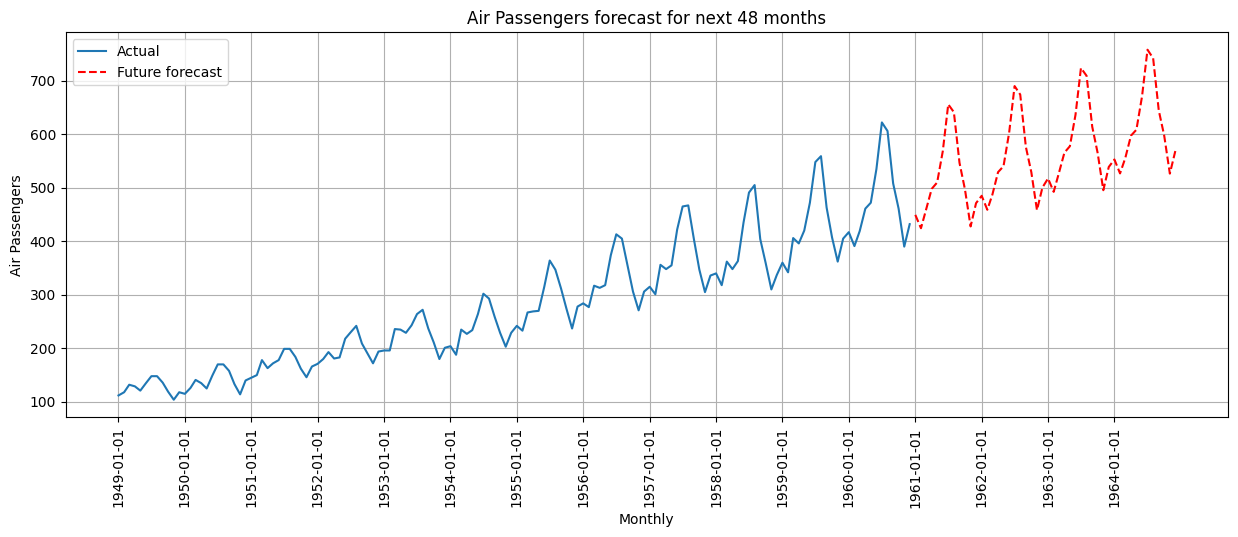

In [28]:
# Future forecast
steps=48 # months

y_pred=model.forecast(steps=steps)
final=pd.Series(df['Passengers'], index=df.index)
final=final.add(y_pred, fill_value=0)

# plot
plt.figure(figsize=(15,5)) 
plt.plot(final[:-steps], label='Actual')
plt.plot(final[-steps:], color='red', linestyle="--", label='Future forecast')
plt.xticks(final.index[0::12], rotation ='vertical')
plt.legend(loc="upper left")
plt.xlabel("Monthly")
plt.ylabel("Air Passengers")
plt.title("Air Passengers forecast for next 48 months")
plt.grid()
plt.show()

**Summary:**  
In this notebook we have analysed, tested and built a forecasting model to predict the future values of Air passengers